In [385]:
#Importaciones Necesarias
#setx CURL_SSL_NO_REVOKE 1
#setx CURL_SSL_NO_REVOKE ""

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import Angle
import astropy.units as u
import pandas as pd
import os
import shutil
import subprocess
from IPython.display import clear_output
import csv
from datetime import datetime
from astropy.time import Time
import matplotlib.pyplot as plt
from astroquery.mast import Tesscut
from scipy.signal import periodogram
import numpy as np
import requests

In [374]:
#Se define la función que obtiene la info de Simbad
Gaia.ROW_LIMIT = -1 
Ra,Dec=0,0
tiempo=[]
magnitud=[]
sector_seleccionado=0
gaia_id=0
object_name="a"
def get_coordinates_from_name(name):
    simbad = Simbad()
    result = simbad.query_object(name)
    if result is not None:
        ra = result['ra'][0] 
        dec = result['dec'][0]
        ra_hms = Angle(ra, unit=u.deg).to_string(unit=u.hourangle, sep=':', precision=7)
        dec_dms = Angle(dec, unit=u.deg).to_string(unit=u.deg, sep=':', precision=6, alwayssign=True)
        global Ra
        global Dec 
        Dec = dec
        Ra = ra
        return ra, dec,ra_hms,dec_dms
    else:
        raise ValueError(f"No se encontraron coordenadas para el objeto {name}")
        
#Se define la función que toma las coordenadas y hace el query en gaia
def query_gaia(ra, dec, radius_arcmin=1):
    radius_deg = radius_arcmin / 60.0  # Conversión: 1 arcmin = 1/60 grados
    try:
        # Realizar la consulta en Gaia
        job = Gaia.launch_job_async(f"""
            SELECT  ra, dec,source_id
            FROM gaiadr2.gaia_source
            WHERE CONTAINS(POINT('ICRS', ra, dec), 
                           CIRCLE('ICRS', {ra}, {dec}, {radius_deg})) = 1
        """)
        results = job.get_results()
        return results
    except Exception as e:
        print("Error en la consulta:", e)
        return None
        
#Obtener el ID de gaia
def gaia_ids():
    Simbad.add_votable_fields("ids")
    result = Simbad.query_object(object_name)
    if result is not None:
        ids = result["ids"][0].split("|")
        for id_ in ids:
            if "Gaia DR2" in id_:
                global gaia_id
                gaia_id = int(id_.replace("Gaia DR2 ", ""))
                print(f"🔍 Gaia DR2 ID de {object_name}: {gaia_id}")        
    else:
        return f"No se encontró el objeto '{object_name}' en Simbad."

#Se define la función que guarda los archivos en el csv como catálogo
def obtener_catalogo():
    ra, dec,ra_hms,dec_dms= get_coordinates_from_name(object_name)
    print(f"Coordenadas de {object_name} - RA: {ra}°, DEC: {dec}°")
    print(f"Coordenadas de {object_name} - RA_HMS: {ra_hms}, DEC_DMS: {dec_dms}")
    
    results = query_gaia(ra, dec, radius_arcmin=radius_arcmin)
    
    print(f"Se hallaron {len(results)} objetos")
    print(f"✅ Catálogo descargado")
    data = results.to_pandas()
    data.to_csv(f'datos_gaia3edr.csv',index = False, header=False,sep=" ")
    rows, columns = data.shape
    

In [375]:
def Definir_sector():
    print(f"Para el objeto {object_name} se tienen los sectores:")
    sectors = Tesscut.get_sectors(objectname=object_name)
    print(f"\n{sectors}\n")
    global sector_seleccionado
    sector_seleccionado = input("Ingrese el sector a analizar:")
    catalogo_sector= f"tesscurl_sector_{sector_seleccionado}_ffic.sh"
    
    if catalogo_sector in os.listdir("."):
        print(f"✅ Archivo .sh del sector listo")
    else:
        print(f"El Archivo .sh del sector {sector_seleccionado} no se encuentra en la carpeta {os.path.basename(os.getcwd())}")
        url = f"https://archive.stsci.edu/missions/tess/download_scripts/sector/tesscurl_sector_{sector_seleccionado}_ffic.sh"
        print(f"Se procede a descargarlo...")
        carpeta_destino = os.getcwd() 
        nombre_archivo = f"tesscurl_sector_{sector_seleccionado}_ffic.sh"
        ruta_completa = os.path.join(carpeta_destino, nombre_archivo)
        response = requests.get(url)
        
        if response.status_code == 200:
            with open(ruta_completa, "wb") as file:
                file.write(response.content)
            print(f"✅ Archivo descargado en: {ruta_completa}")
        else:
            print(f"❌ Error")


In [376]:
#Comprobación del directorio de Trabajo, de fallar regersar a la carpeta principal
dest_dir ="./imagenes"
current_dir = os.getcwd()
current_folder = os.path.basename(current_dir)
if f'./{current_folder}' == dest_dir:
    print(f"Estás dentro de {current_folder}. Saliendo...")
    os.chdir("..") 
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    
#Definir la función que descarga las imagenes del archivo .sh
def ejecutar_curl_desde_archivo(archivo_sh, linea_inicio, linea_final):
    with open(archivo_sh, "r") as archivo:
        for i, linea in enumerate(archivo):
            if i < linea_inicio:
                continue
            if i > linea_final:
                break

            linea = linea.strip()

            print(f"⏳Descargando imagen {i} de {linea_final}")
            print(f"Ejecutando: {linea}")
            os.chdir(dest_dir)
            try:
                result = subprocess.run(linea, shell=True, text=True)
            except Exception as e:
                print(f"⚠️Error al ejecutar la línea {linea}: {e}")
            
            os.chdir("..")
            clear_output(wait=True)
            

In [377]:
#Se define la función principal, esta descarga imágenes y las analiza con phot3.py
def Descarga_y_analizis():
    with open(f"tesscurl_sector_{sector_seleccionado}_ffic.sh", "rb") as archivo:  # Modo binario para mayor velocidad
        print(f"Es posible descargar {sum(1 for _ in archivo)} imágenes del sector {sector_seleccionado}")
    print("Seleccione el rango de imagenes a descargar; tenga en cuenta que cada una pesa ~34mb")
    inicio = int(input("Imagen de inicio"))
    fin =  int(input("Imagen final"))
    print(f"\nSe descargaran {fin-inicio} imagenes, se necesitan ~{(fin-inicio)*34}mb")
    switch= input("continuar? [y/n]")
    if switch=="y":
        dest_dir ="./imagenes"
        current_dir = os.getcwd()
        current_folder = os.path.basename(current_dir)
        if f'./{current_folder}' == dest_dir:
            print(f"Estás dentro de {current_folder}. Saliendo...")
            os.chdir("..") 
    
        ejecutar_curl_desde_archivo(f"tesscurl_sector_{sector_seleccionado}_ffic.sh",inicio, fin)
        with open(f"tesscurl_sector_{sector_seleccionado}_ffic.sh", "rb") as archivo:  # Modo binario para mayor velocidad
            print(f"Es posible descargar {sum(1 for _ in archivo)} imágenes del sector")
        print(f"✅Descarga de las imagenes {inicio} a la {fin} Finalizada")
        print("⏳Analizando las imagenes...")
        
        result = subprocess.run("python phot3.py", shell=True, capture_output=True, text=True)
        print(result.stdout)
        print(result.stderr)
        
        shutil.rmtree("./imagenes")
        os.makedirs("./imagenes", exist_ok=True)
        print("\n✅Imagenes borradas de la carpeta imagenes, proceso finalizado ")
    else:
        print(f"❌ Cancelado")

In [378]:
#Esto lo que hace es analizar los datos csv, y construir las dos listas con los datos a graficar
def conteo_datos():
    gaia_ids()
    nombre_carpeta = "csv_out"
    directorio = os.getcwd()
    directorio= os.path.basename(directorio)
    if not f'{directorio}' == nombre_carpeta:
        os.chdir("./csv_out")
    fechas=[]
    magnitudes=[]
    #Proceso de iteración
    for archivo in os.listdir("./"):
            with open(archivo, mode='r', newline='', encoding='utf-8') as archivo_csv:
                lector = csv.reader(archivo_csv)
                for fila in lector:
                    if fila[0] == str(gaia_id) : #Definir id de simbad del objeto
                        fechas.append(fila[5])
                        magnitudes.append(float(fila[3]))
    global tiempo
    global magnitud
    tiempo=fechas
    magnitud=magnitudes
    
    print(f"Datos agregados correctamente, actualmente se cuenta con {len(magnitudes)} datos")
    os.chdir("..")

In [379]:
#La gráfica no habria que mover nada aquí
def curvadeluz():
    global tiempo
    global magnitud
    
    fechas_clean = [Time(f, format='isot', scale='utc').jd for f in tiempo]
    fechas_clean_2 = [datetime.strptime(f, "%Y-%m-%dT%H:%M:%S.%f") for f in tiempo]
    
    flujos=[]
    for i in magnitud:
        flujos.append(10**(-i/2.5))
    
    plt.rcParams.update({
        'axes.facecolor': '#121212',  # Fondo del área del gráfico (gris oscuro)
        'figure.facecolor': '#121212',  # Fondo de la figura (gris oscuro)
        'font.family': 'Arial',  # Fuente
        'font.size': 10 ,  # Tamaño de la fuente
        'axes.labelcolor': 'white',  # Color de las etiquetas de los ejes (blanco)
        'xtick.color': 'white',  # Color de las etiquetas en el eje X (blanco)
        'ytick.color': 'white',  # Color de las etiquetas en el eje Y (blanco)
        'axes.edgecolor': 'white',  # Color de los bordes del gráfico (blanco)
        'grid.color': '#404040',  # Color de la cuadrícula (gris claro)
        'grid.linestyle': '--',  # Estilo de la cuadrícula (líneas discontinuas)
        'grid.alpha': 0.3,  # Transparencia de la cuadrícula (más suave)
        'lines.color': 'cyan',  # Color de las líneas (cian brillante)
        'lines.linewidth': 2,  # Ancho de las líneas
        'axes.titlecolor': 'white',  # Color del título de los ejes (blanco)
    })

    alto,ancho=4,8
    plt.figure(figsize=(ancho, alto))  
    plt.plot(fechas_clean[:], flujos[:], marker='o', linestyle='-', color="white",markerfacecolor='none', linewidth=1)
    plt.xlabel("Tiempo Juliano",fontsize=10,labelpad=20)
    plt.ylabel("Flujo",fontsize=10,labelpad=20) 
    plt.title(f"----------------Curva de luz para {object_name}----------------".upper(), fontsize=10,pad=10)
    
    plt.show()


In [380]:
def periodograma():
    fechas_clean = [Time(f, format='isot', scale='utc').jd for f in tiempo]
    fechas_clean_2 = [datetime.strptime(f, "%Y-%m-%dT%H:%M:%S.%f") for f in tiempo]
    flujos=[]
    for i in magnitud:
        flujos.append(10**(-i/2.5))
    frequencies, power = periodogram(flujos, 1/(fechas_clean[1]-fechas_clean[0]))
    indice_max = np.argmax(power)
    frecuencia_max = frequencies[indice_max]
    
    print("La frecuencia con el valor máximo de potencia es:", 1/frecuencia_max)
    print("El valor máximo de potencia es:", power[indice_max])
    
    alto,ancho=4,8
    plt.figure(figsize=(ancho, alto))  
    plt.plot(1/frequencies[1:], power[1:], marker='o', linestyle='-', color="white",markerfacecolor='none', linewidth=1)
    plt.xlabel("Periodo en dias",fontsize=10,labelpad=20)
    plt.ylabel("Potencia",fontsize=10,labelpad=20) 
    plt.title(f"----------------Periodograma para {object_name}----------------".upper(), fontsize=10,pad=10)
    
    plt.show()

In [382]:
#Obtención del Catálogo
object_name = input("Ingresa el nombre del objeto: ")
radius_arcmin = float(input("Ingresa el radio de búsqueda en arcominutos: "))

Ingresa el nombre del objeto:  lambda tau
Ingresa el radio de búsqueda en arcominutos:  10


In [383]:
obtener_catalogo()

Coordenadas de lambda tau - RA: 60.1700698910475°, DEC: 12.49034444100722°
Coordenadas de lambda tau - RA_HMS: 4:00:40.8167739, DEC_DMS: +12:29:25.239988
INFO: Query finished. [astroquery.utils.tap.core]
Se hallaron 497 objetos
✅ Catálogo descargado


In [387]:
Definir_sector()

Para el objeto lambda tau se tienen los sectores:

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0005-1-4      5      1   4
tess-s0032-1-4     32      1   4
tess-s0042-4-3     42      4   3
tess-s0043-3-2     43      3   2
tess-s0044-1-1     44      1   1
tess-s0070-4-2     70      4   2
tess-s0071-2-4     71      2   4



Ingrese el sector a analizar: 5


✅ Archivo .sh del sector listo


In [391]:
Descarga_y_analizis()

Es posible descargar 19137 imágenes del sector
✅Descarga de las imagenes 5600 a la 5600 Finalizada
⏳Analizando las imagenes...

Su carpeta contiene 1 archivos .fits 

No. 1: tess2018326102938-s0005-1-4-0125-s_ffic.fits
          ....            
No. 1: tess2018326102938-s0005-1-4-0125-s_ffic.fits



 
 Se obtuvieron 1 archivos .csv
Archivos .fits.out almacenados en fits_out
Archivos .csv almacenados en csv_out



✅Imagenes borradas de la carpeta imagenes, proceso finalizado 


In [393]:
conteo_datos()

🔍 Gaia DR2 ID de lambda tau: 3305012316783145728
Datos agregados correctamente, actualmente se cuenta con 341 datos


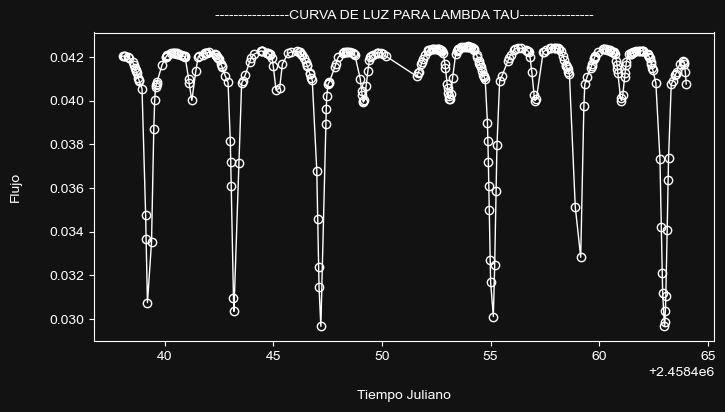

In [395]:
curvadeluz()

La frecuencia con el valor máximo de potencia es: 4.059589760511049
El valor máximo de potencia es: 2.3427468327668974e-05


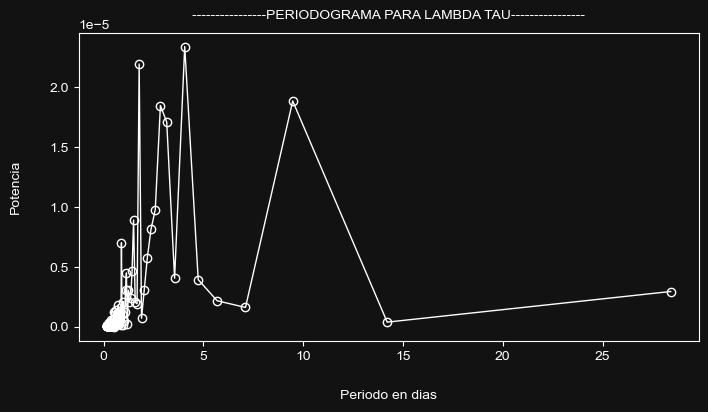

In [397]:
periodograma()